In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
def RGB_to_YCbCr(original_img):
    img = original_img.copy().astype(np.float32)
    R, G, B = img[..., 2], img[..., 1], img[..., 0]
    Y = 0.299 * R + 0.5870 * G + 0.114 * B
    Cb = -0.1687 * R - 0.3313 * G + 0.5 * B + 128
    Cr = 0.5 * R - 0.4187 * G - 0.0813 * B + 128
    return [Y, Cb, Cr]

def YCbCr_to_RGB(original_img):
    img = original_img.copy().astype(np.float32)
    Y, Cb, Cr = img[..., 0], img[..., 1], img[..., 2]
    R = Y + (Cr - 128) * 1.402
    G = Y - (Cb - 128) * 0.3441 - (Cr - 128) * 0.7139
    B = Y + (Cb - 128) * 1.7718
    return [R, G, B]

In [3]:
def w(u, v, x, y, T):
    cu = 1 if u != 0 else 1/np.sqrt(2)
    cv = 1 if v != 0 else 1/np.sqrt(2)
    theta = np.pi / (2*T)
    return cu * cv * np.cos((2*x+1)*u*theta) * np.cos((2*y+1)*v*theta)

In [4]:
def dct(img, width=8):
    H, W, ch = img.shape
    F = np.zeros(img.shape, dtype=np.float32)
    for c in range(ch):
        for sx in range(0, H, width):
            for sy in range(0, W, width):
                for i in range(width):
                    for j in range(width):
                        for x in range(width):
                            for y in range(width):
                                F[sx+i, sy+j, c] += 2/width * img[sx+x, sy+y, c] * w(i, j, x, y, width)
    return F

In [5]:
def idct(F, width=8, K=8):
    H, W, ch = F.shape
    f = np.zeros(img.shape, dtype=np.float32)
    for c in range(ch):
        for sx in range(0, H, width):
            for sy in range(0, W, width):
                for x in range(width):
                    for y in range(width):
                        for i in range(K):
                            for j in range(K):
                                f[sx+x, sy+y, c] += 2/width * F[sx+i, sy+j, c] * w(i, j, x, y, width)
    f = np.clip(f, 0, 255).astype("uint8")
    return f

In [6]:
Q1 = np.array(((16, 11, 10, 16, 24, 40, 51, 61),
               (12, 12, 14, 19, 26, 58, 60, 55),
               (14, 13, 16, 24, 40, 57, 69, 56),
               (14, 17, 22, 29, 51, 87, 80, 62),
               (18, 22, 37, 56, 68, 109, 103, 77),
               (24, 35, 55, 64, 81, 104, 113, 92),
               (49, 64, 78, 87, 103, 121, 120, 101),
               (72, 92, 95, 98, 112, 100, 103, 99)), dtype=np.float32)

Q2 = np.array(((17, 18, 24, 47, 99, 99, 99, 99),
               (18, 21, 26, 66, 99, 99, 99, 99),
               (24, 26, 56, 99, 99, 99, 99, 99),
               (47, 66, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99)), dtype=np.float32)

In [15]:
def quantize(F, Q, width=8):
    H, W = F.shape
    
    R = np.zeros(F.shape)
    for sx in range(0, H, width):
        for sy in range(0, W, width):
            for x in range(width):
                for y in range(width):
                    R[sx+x, sy+y] = np.round(F[sx+x, sy+y] / Q[x][y])
                        
    return R

def restore(R, Q, width=8):
    H, W = R.shape
    
    F = np.zeros(R.shape)
    for sx in range(0, H, width):
        for sy in range(0, W, width):
            for x in range(width):
                for y in range(width):
                    F[sx+x, sy+y] = R[sx+x, sy+y] * Q[x][y]
    return F

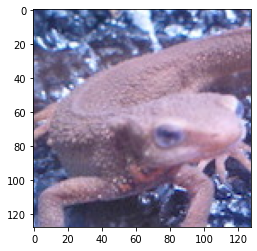

In [8]:
img = cv2.imread("../imori.jpg")
H, W, ch = img.shape
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [46]:
Y, Cb, Cr = RGB_to_YCbCr(img)
converted_img = np.swapaxes(np.swapaxes(np.array([Y, Cb, Cr]), 0, 2), 0, 1)

F = dct(converted_img)

In [47]:
F[..., 0] = quantize(F[..., 0], Q1)
F[..., 1] = quantize(F[..., 1], Q2)
F[..., 2] = quantize(F[..., 2], Q2)

In [48]:
F[..., 0] = restore(F[..., 0], Q1)
F[..., 1] = restore(F[..., 1], Q2)
F[..., 2] = restore(F[..., 2], Q2)

In [49]:
K = 8
converted_img_2 = idct(F, width=8, K=K)

In [59]:
R, G, B = YCbCr_to_RGB(converted_img_2)

(128, 128, 3)


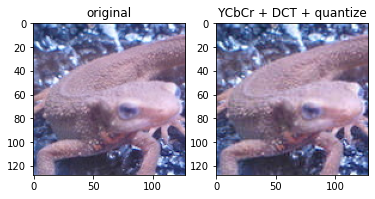

True

In [61]:
output_img = np.swapaxes(np.swapaxes(np.array([B, G, R]), 0, 2), 0, 1)
output_img = np.clip(output_img, 0, 255).astype("uint8")
print(output_img.shape)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("original")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title("YCbCr + DCT + quantize")
plt.show()

cv2.imwrite("out_040.jpg", output_img)